version 35

In [1]:
import os
import multiprocessing as mp

# Then import other libraries and define your code
import random
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.metrics import confusion_matrix, average_precision_score
from sklearn.metrics import multilabel_confusion_matrix as ConfusionMatrix
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from transformers import get_cosine_schedule_with_warmup
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from torchvision.models import resnet50, ResNet50_Weights

import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.strategies import DDPStrategy
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
 
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, MulticlassF1Score

from bayes_opt import BayesianOptimization
from tqdm import tqdm
import timm

# Model

In [2]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y

In [3]:
class ResNetWrapper(pl.LightningModule):
    def __init__(self, lr, sigmoid_threshold=0.5, dropout_rate = 0.5):
        super().__init__()
        self.lr = lr
        self.dropout_rate   = dropout_rate  
        self.sigmoid_threshold = sigmoid_threshold
        self.validation_step_y_hats = []
        self.validation_step_ys = []

        backbone = timm.create_model('seresnet152d', pretrained=True, num_classes=80)
        layers = list(backbone.children())[:-1]  # Remove the final fully connected layer
        self.feature_extractor = nn.Sequential(*layers)

        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        layers.insert(-1, SEBlock(in_channels=2048))  # 2048 az utolsó réteg csatornáinak száma ResNet50 esetén

        self.classifier = nn.Sequential(
            # nn.Dropout(self.dropout_rate), # hyperparameter
            nn.Linear(backbone.fc.in_features, out_features=80)
        )
        
        self.loss_fn = nn.BCEWithLogitsLoss()

        self.train_acc = Accuracy(task="multilabel",num_labels=80)
        self.val_acc = Accuracy(task="multilabel",num_labels=80)
        self.train_precision = Precision(task="multilabel",num_labels=80)
        self.val_precision = Precision(task="multilabel",num_labels=80)
        self.train_recall = Recall(task="multilabel",num_labels=80)
        self.val_recall = Recall(task="multilabel",num_labels=80)
        self.train_f1 = F1Score(task="multilabel",num_labels=80)
        self.val_f1 = F1Score(task="multilabel",num_labels=80)


    def forward(self, x):
        x = self.feature_extractor(x) 
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.sigmoid(logits) > self.sigmoid_threshold

        # Update metrics
        self.train_acc.update(preds, y)
        self.train_precision.update(preds, y)
        self.train_recall.update(preds, y)
        self.train_f1.update(preds, y)
        self.log('train_acc', self.train_acc)
        self.log('train_precision', self.train_precision)
        self.log('train_recall', self.train_recall)
        self.log('train_f1', self.train_f1)
        
        return loss
    def on_train_epoch_end(self):
        # Reset training metrics at the end of the epoch
        self.train_acc.reset()
        self.train_precision.reset()
        self.train_recall.reset()
        self.train_f1.reset()

        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        
        preds = torch.sigmoid(logits) > self.sigmoid_threshold
        self.val_acc.update(preds, y)
        self.val_precision.update(preds, y)
        self.val_recall.update(preds, y)
        self.val_f1.update(preds, y)
    
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, on_step=False)
        return {"val_loss": loss}
    

            
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.sigmoid(logits) > self.sigmoid_threshold
    
        self.log("test_preds", preds)
        self.log("test_targets", y)

    
        self.validation_step_y_hats.append(preds.cpu())
        self.validation_step_ys.append(y.cpu())
        return {'preds': preds, 'targets': y}

        
    def on_validation_epoch_end(self):
        self.log('val_acc', self.val_acc.compute(), on_epoch=True, prog_bar=True)
        self.log('val_precision', self.val_precision.compute(), on_epoch=True, prog_bar=True)
        self.log('val_recall', self.val_recall.compute(), on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1.compute(), on_epoch=True, prog_bar=True)
        self.val_acc.reset()
        self.val_precision.reset()
        self.val_recall.reset()
        self.val_f1.reset()


    def on_epoch_start(self):
        current_lr = self.optimizers().param_groups[0]['lr']
        self.log('lr', current_lr, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        # Total number of training steps (epochs * steps_per_epoch)
        total_training_steps = (
            len(self.trainer.datamodule.train_dataloader()) // self.trainer.world_size
        ) * self.trainer.max_epochs
        warmup_steps = int(0.1 * total_training_steps)  # 10% of total steps for warmup
        
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, 
            num_warmup_steps=warmup_steps, 
            num_training_steps=total_training_steps
        )
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

# Data handling

In [4]:

def target_to_oh(target):
    NUM_CLASSES = 80  # Number of classes
    one_hot = torch.zeros(NUM_CLASSES)  # Create a tensor of zeros with shape (NUM_CLASSES,)
    one_hot[target] = 1  # Set the correct class index to 1
    return one_hot




def create_train_test_split_proportional(dataset, test_ratio=0.1, seed=42, transform=None):
    """
    Create a train-test split proportional to the dataset's labels.

    Args:
        dataset (ImageFolder): The dataset to split.
        test_ratio (float): Proportion of the dataset to include in the test split.
        seed (int): Random seed for reproducibility.
        transform: Image transformation for preprocessing.

    Returns:
        train_dataset, test_dataset, idx_to_label: The train/test split datasets and label mapping.
    """
    random.seed(seed)

    # Group samples by label
    label_to_samples = defaultdict(list)
    for sample in dataset.samples:
        label_to_samples[sample[1]].append(sample)

    train_samples = []
    test_samples = []

    # Split the dataset into train and test samples
    for label, samples in label_to_samples.items():
        random.shuffle(samples)
        num_test = int(len(samples) * test_ratio)
        test_samples.extend(samples[:num_test])
        train_samples.extend(samples[num_test:])

    # Create ImageFolder datasets for train and test
    train_dataset = ImageFolder(dataset.root, transform=transform)
    train_dataset.samples = train_samples
    train_dataset.targets = [sample[1] for sample in train_samples]  # Update targets

    test_dataset = ImageFolder(dataset.root, transform=transform)
    test_dataset.samples = test_samples
    test_dataset.targets = [sample[1] for sample in test_samples]  # Update targets

    # Use the class_to_idx from the original dataset for label mapping
    idx_to_label = {v: k for k, v in dataset.class_to_idx.items()}

    return train_dataset, test_dataset, idx_to_label


class MyDataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_dataset = None, batch_size=32, num_workers=4, persistent_workers=True):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.persistent_workers = persistent_workers

    def train_dataloader(self):
        train_dataset_with_transform = [(x, target_to_oh(y)) for x, y in self.train_data]
  
        train_loader = DataLoader(train_dataset_with_transform, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, persistent_workers = self.persistent_workers)
     
        return train_loader


    def val_dataloader(self):
        val_dataset_with_transform = [(x, target_to_oh(y)) for x, y in self.val_data]
        val_loader = torch.utils.data.DataLoader(
                    val_dataset_with_transform, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers = self.persistent_workers)

        return val_loader        
    def test_dataloader(self):
        test_dataset_with_transform = [x for x in self.test_data]  # Csak képeket tárolunk
        print(len(test_dataset_with_transform))
        return DataLoader(test_dataset_with_transform, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.persistent_workers)

In [5]:
transform_ = transforms.Compose([ 
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Apply exclusions
dataset = ImageFolder('125images', transform=None)
print(f"Original dataset size: {len(dataset)}")


# Create the train-test split and update label mapping
train_dataset, test_dataset, idx_to_label = create_train_test_split_proportional(dataset, test_ratio=0.08, seed=42, transform=transform_)
print()
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}", '\n')
print("Unique class indices in dataset:", set([sample[1] for sample in dataset.samples]), '\n')
print("Number of unique classes:", len(set([sample[1] for sample in dataset.samples])), '\n')
print("Train label distribution:", Counter([sample[1] for sample in train_dataset.samples]), '\n')
print("Test label distribution:", Counter([sample[1] for sample in test_dataset.samples]), '\n')


Original dataset size: 10000

Train dataset size: 9200
Test dataset size: 800 

Unique class indices in dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79} 

Number of unique classes: 80 

Train label distribution: Counter({0: 115, 1: 115, 2: 115, 3: 115, 4: 115, 5: 115, 6: 115, 7: 115, 8: 115, 9: 115, 10: 115, 11: 115, 12: 115, 13: 115, 14: 115, 15: 115, 16: 115, 17: 115, 18: 115, 19: 115, 20: 115, 21: 115, 22: 115, 23: 115, 24: 115, 25: 115, 26: 115, 27: 115, 28: 115, 29: 115, 30: 115, 31: 115, 32: 115, 33: 115, 34: 115, 35: 115, 36: 115, 37: 115, 38: 115, 39: 115, 40: 115, 41: 115, 42: 115, 43: 115, 44: 115, 45: 115, 46: 115, 47: 115, 48: 115, 49: 115, 50: 115, 51: 115, 52: 115, 53: 115, 54: 115, 55: 115, 56: 115, 57: 1

In [7]:
# KFold Cross-Validation
batch_size = 23
lr = 0.008274600824983372
threshold = 0.3527
dropout_rate=0.3
lr = 0.007323



# Train

In [21]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
val_losses = []

# Assuming you have `train_dataset` defined as an ImageFolder dataset
for fold, (train_idx, val_idx) in tqdm(enumerate(kf.split(np.arange(len(train_dataset)))), total=kf.get_n_splits(), desc="K-Fold Cross-Validation"):
    print(f"Fold {fold + 1}/{kf.n_splits}")


    # Split the dataset into train and validation subsets using indices
    train_subset = Subset(train_dataset, train_idx)  
    val_subset = Subset(train_dataset, val_idx)

    # Create Data Module for each fold
    data_module = MyDataModule(train_subset, val_subset, batch_size, num_workers=4, persistent_workers=True)

    # Setup the model for multilabel classification
    model = ResNetWrapper(lr=lr, sigmoid_threshold=threshold, dropout_rate=dropout_rate)

    # Logger
    logger = TensorBoardLogger("lightning_logs_no_dropout", name=f"multilabel_training_fold_{fold}")

    # ModelCheckpoint to save only the best models (monitor F1 score for multilabel)
    checkpoint_callback = ModelCheckpoint(
        monitor="val_f1",  # Monitor validation F1 score
        mode="max",        # Maximize the F1 score
        save_top_k=1,      # Save only the best model
        filename="{epoch}-{val_f1:.4f}"
    )

    # EarlyStopping based on F1 score
    early_stopping = EarlyStopping(
        monitor="val_f1",  # Use F1 for stopping
        patience=2,        # Stop after 3 non-improving epochs
        mode="max"
    )

    # Setup the Trainer
    trainer = Trainer(
        logger=logger,
        max_epochs=30,
        devices='auto',  # Adjust based on your hardware
        accelerator="mps",  # Use "gpu" or "tpu" based on availability
        callbacks=[early_stopping, checkpoint_callback],
        fast_dev_run=False
    )

    # Train the model
    trainer.fit(model, datamodule=data_module)

    # Log validation loss for this fold
    val_losses.append(trainer.callback_metrics["val_loss"].item())

# After cross-validation, retrieve the best model path
best_model_path = checkpoint_callback.best_model_path
print("Best model saved at:", best_model_path)

K-Fold Cross-Validation:   0%|                                                                                                                                           | 0/5 [00:00<?, ?it/s]

Fold 1/5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

K-Fold Cross-Validation:  20%|█████████████████████████▍                                                                                                     | 1/5 [19:54<1:19:38, 1194.73s/it]

Fold 2/5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

K-Fold Cross-Validation:  40%|██████████████████████████████████████████████████▊                                                                            | 2/5 [53:40<1:24:10, 1683.55s/it]

Fold 3/5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

K-Fold Cross-Validation:  60%|███████████████████████████████████████████████████████████████████████████                                                  | 3/5 [4:00:12<3:20:50, 6025.38s/it]

Fold 4/5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

K-Fold Cross-Validation:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4/5 [4:24:07<1:10:12, 4212.97s/it]

Fold 5/5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                | Params | Mode 
-------------------------------------------------------------------
0  | feature_extractor | Sequential          | 64.8 M | train
1  | classifier        | Sequential          | 163 K  | train
2  | loss_fn           | BCEWithLogitsLoss   | 0      | train
3  | train_acc         | MultilabelAccuracy  | 0      | train
4  | val_acc           | MultilabelAccuracy  | 0      | train
5  | train_precision   | MultilabelPrecision | 0      | train
6  | val_precision     | MultilabelPrecision | 0      | train
7  | train_recall      | MultilabelRecall    | 0      | train
8  | val_recall        | MultilabelRecall    | 0      | train
9  | train_f1          | MultilabelF1Score   | 0      | train
10 | val_f1            | MultilabelF1Score   | 0      | train
-------------------------------------------------------------------
163 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

K-Fold Cross-Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [4:49:14<00:00, 3470.87s/it]

Best model saved at: lightning_logs_no_dropout/multilabel_training_fold_4/version_0/checkpoints/epoch=6-val_f1=0.6767.ckpt


# Test

None


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


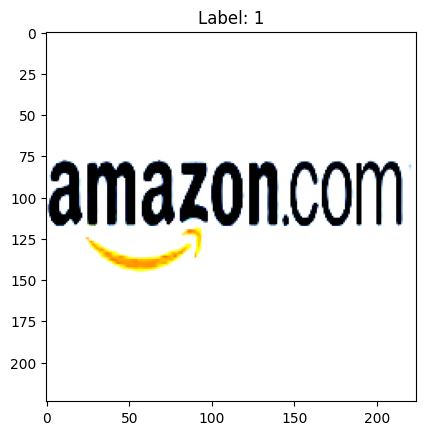

In [12]:
import matplotlib.pyplot as plt
image, label = train_dataset[115]
print(idx_to_label.get(image))

plt.imshow(image.permute(1, 2, 0))  # A csatornákat (C, H, W) átrendezzük (H, W, C) formátumba
plt.title(f"Label: {label}")
plt.show()

In [13]:
from sklearn.metrics import precision_recall_fscore_support, multilabel_confusion_matrix

best_model_path4="lightning_logs_no_dropout_0.6628/multilabel_training_fold_4/version_0/checkpoints/epoch=6-val_f1=0.6767.ckpt"
best_model_path3="lightning_logs_no_dropout_0.6628/multilabel_training_fold_3/version_0/checkpoints/epoch=8-val_f1=0.6591.ckpt"
best_model_path2="lightning_logs_no_dropout_0.6628/multilabel_training_fold_2/version_0/checkpoints/epoch=13-val_f1=0.6667.ckpt"
best_model_path1="lightning_logs_no_dropout_0.6628/multilabel_training_fold_1/version_0/checkpoints/epoch=11-val_f1=0.6642.ckpt"
best_model_path0="lightning_logs_no_dropout_0.6628/multilabel_training_fold_0/version_0/checkpoints/epoch=6-val_f1=0.6609.ckpt"
best_model = ResNetWrapper.load_from_checkpoint(best_model_path, lr=lr, sigmoid_threshold=threshold, dropout_rate=dropout_rate)

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

def evaluate_model(model, test_loader, num_classes=80):
    """Evaluate the model with stored thresholds"""
    model.eval()
    device = next(model.parameters()).device
    all_preds = []
    all_targets = []
    confusion_matrices = []

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            # Model predictions with per-class thresholds
            logits = model(x)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).cpu().numpy()

            # Convert targets to multi-hot encoding if needed
            targets = y.cpu().numpy()
            if targets.ndim == 1:  # If targets are in index format instead of multi-hot
                multi_hot_targets = np.zeros((targets.shape[0], num_classes))
                for i, labels in enumerate(targets):
                    multi_hot_targets[i, labels] = 1  # Convert to one-hot
            else:
                multi_hot_targets = targets  # Already in multi-hot format

            all_preds.append(preds)
            all_targets.append(multi_hot_targets)

    # Concatenate along the first axis
    all_preds = np.concatenate(all_preds, axis=0)  # Shape (N, 80)
    all_targets = np.concatenate(all_targets, axis=0)  # Shape (N, 80)

    print(f"Preds shape: {all_preds.shape}, Targets shape: {all_targets.shape}")

    # Calculate confusion matrices for each class
    confusion_matrices = multilabel_confusion_matrix(all_targets, all_preds)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average=None, zero_division=0
    )

    return precision, recall, f1, confusion_matrices

# Load dataset and create dataloaders
data_module = MyDataModule(train_dataset, train_dataset, test_dataset, batch_size, num_workers=2)
test_loader = data_module.test_dataloader()

for i,model_path in enumerate([best_model_path0, best_model_path1, best_model_path2, best_model_path3, best_model_path4]):
    # Load model
    best_model = ResNetWrapper.load_from_checkpoint(
        model_path,
        lr=lr,
        dropout_rate=dropout_rate
    )
    best_model.eval()

    # Run evaluation
    precision, recall, f1, confusion_matrices = evaluate_model(best_model, test_loader)
    
    # Store confusion matrices for visualization
    mxs = [confusion_matrices]
    
    # Output metrics
    print(f"Fold{i} Macro F1: {np.nanmean(f1):.4f}")


800
Preds shape: (800, 80), Targets shape: (800, 80)
Fold0Macro F1: 0.6466
Preds shape: (800, 80), Targets shape: (800, 80)
Fold1Macro F1: 0.6736
Preds shape: (800, 80), Targets shape: (800, 80)
Fold2Macro F1: 0.6815
Preds shape: (800, 80), Targets shape: (800, 80)
Fold3Macro F1: 0.6609
Preds shape: (800, 80), Targets shape: (800, 80)
Fold4Macro F1: 0.6628


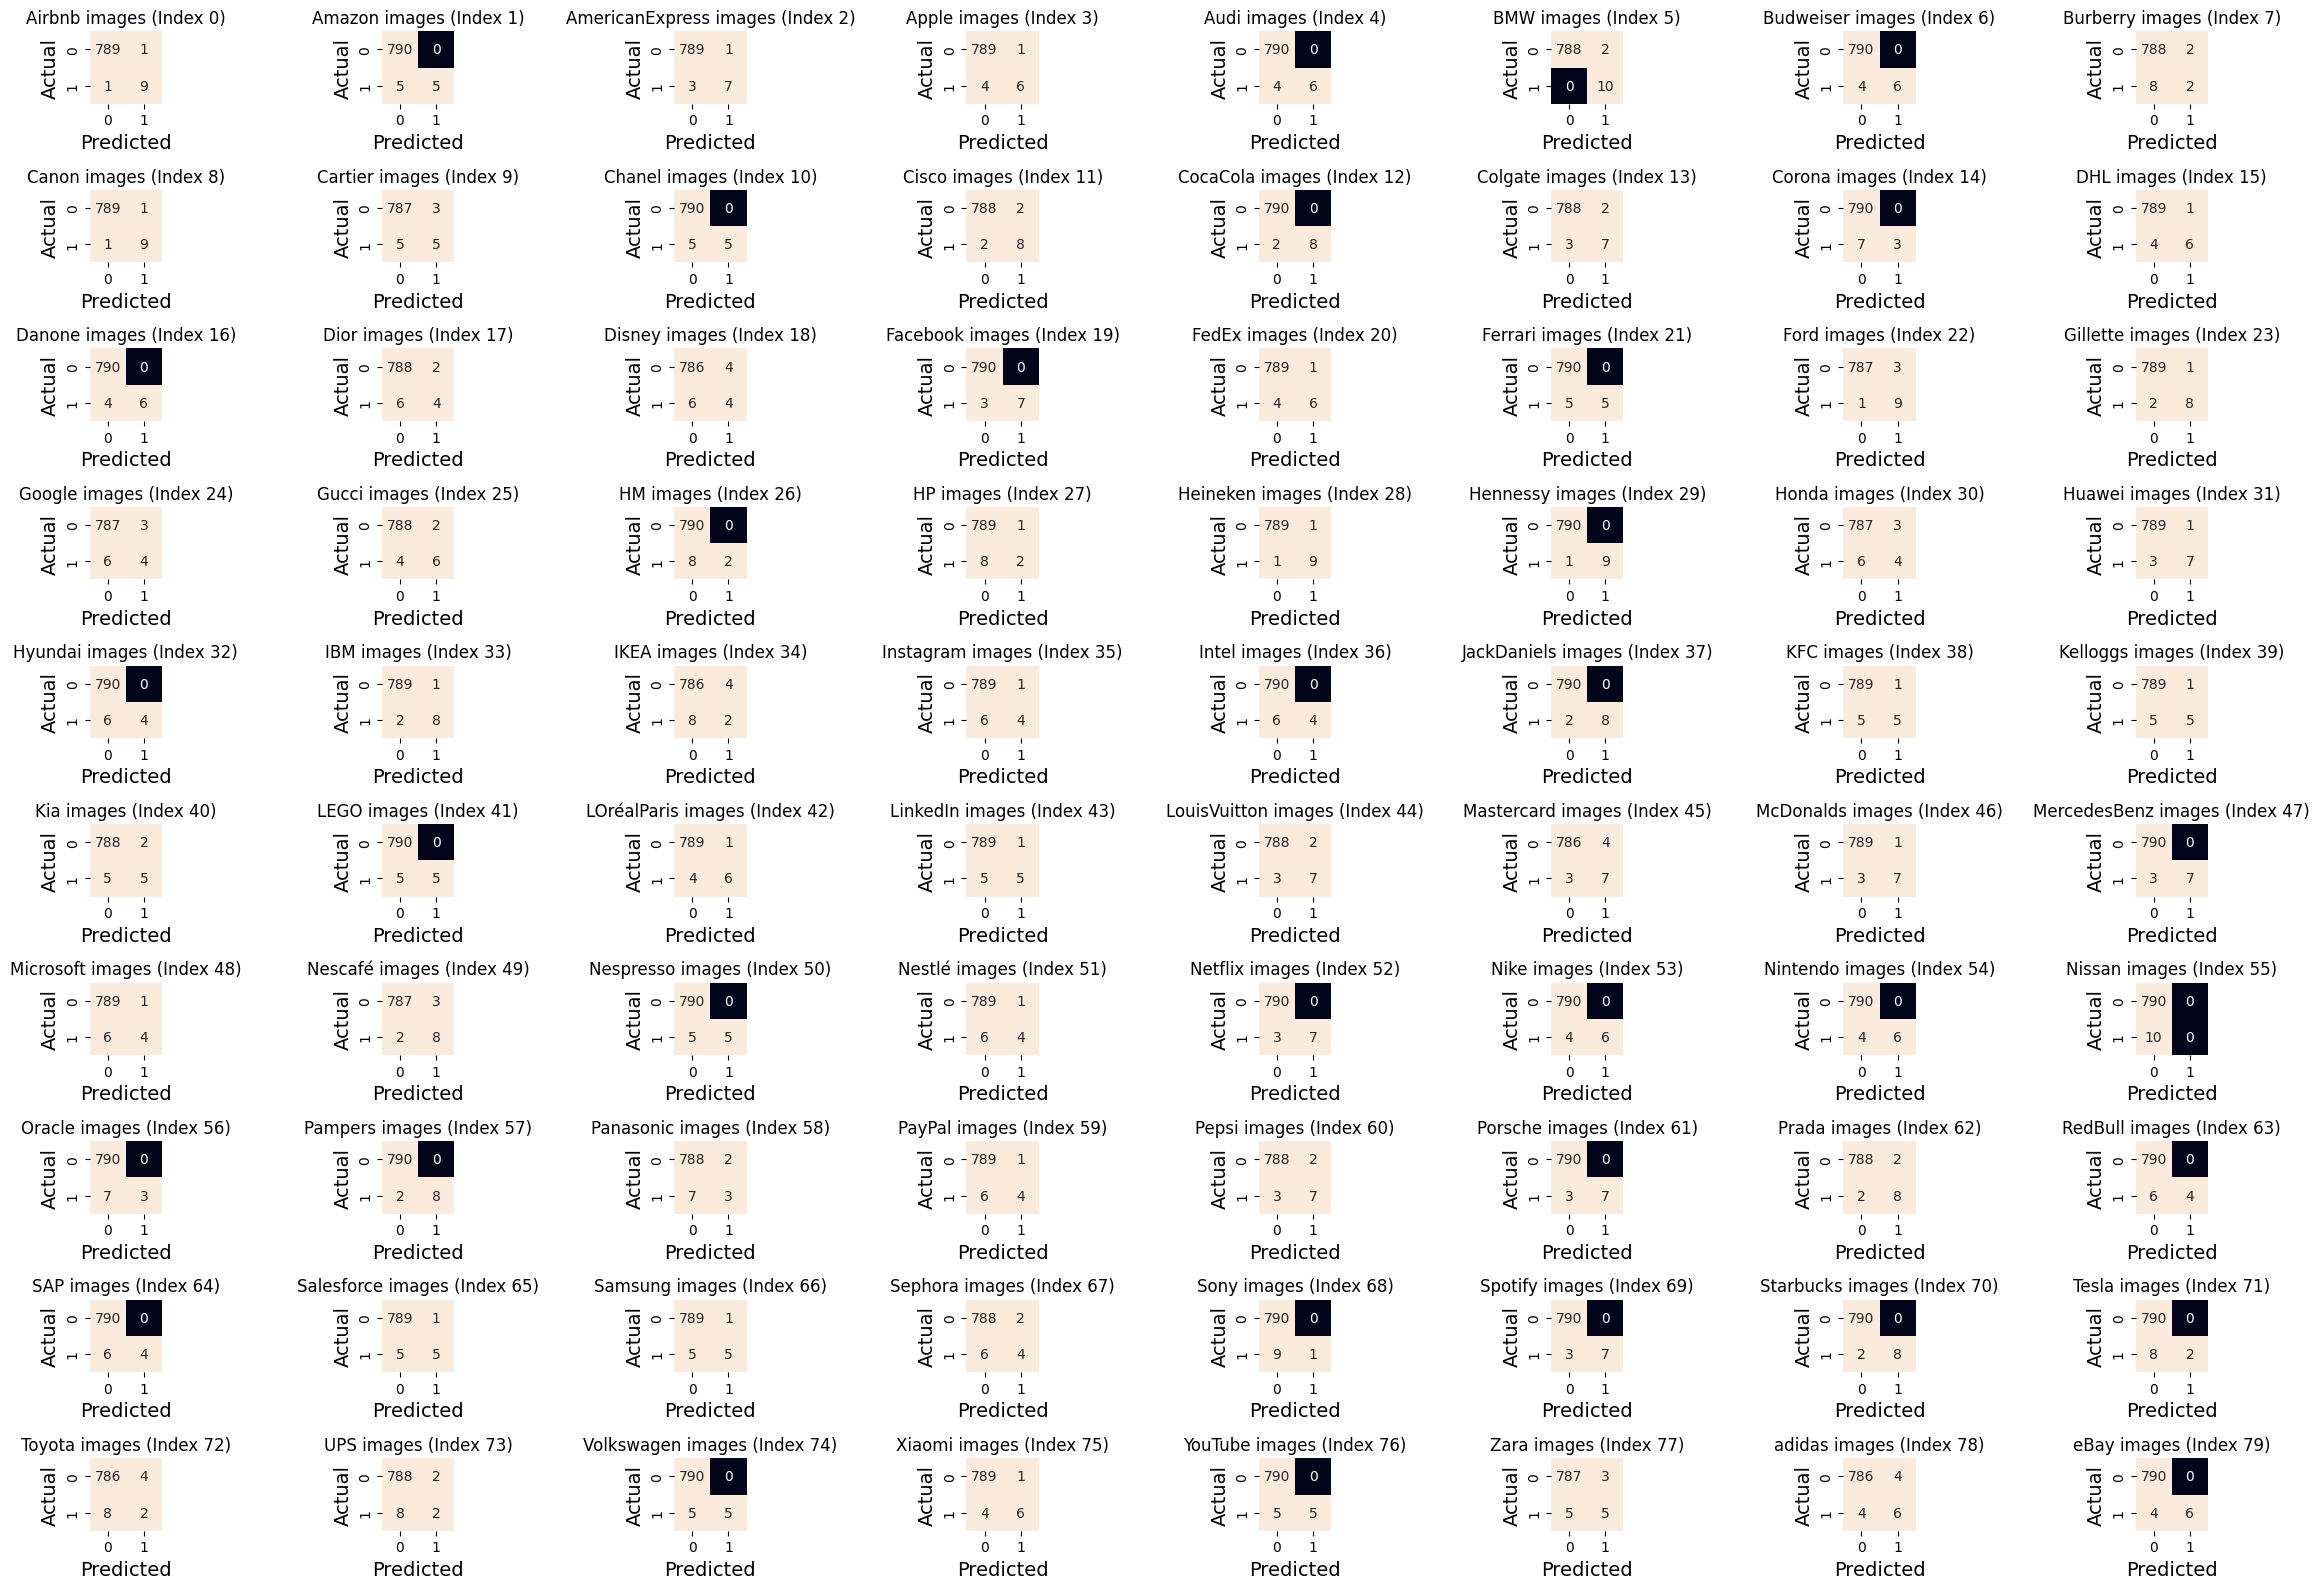

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you already have the reverse index mapping: idx_to_label
mxs_0 = mxs[0]
# Calculate number of rows and columns for the subplots (80 matrices)
n_rows = 10  # You can adjust this for different grid sizes
n_cols = 8   # Adjusted to fit 80 matrices in a grid

# Set up the matplotlib figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 16))  # Adjust the size as needed
axes = axes.ravel()  # Flatten the axes array to index them easily

# Plot each confusion matrix
for i, mx in enumerate(mxs_0):
    ax = axes[i]
    
    # Plot the heatmap with masked zeros
    sns.heatmap(mx, annot=True, fmt='d', vmin=0.5, vmax=1, cbar=False, ax=ax, square=True)
    
    # Set title with the index and label name
    label_name = idx_to_label.get(i, f"Label {i}")  # Get the label name or default to "Label i"
    ax.set_title(f'{label_name} (Index {i})')
    ax.set_xlabel('Predicted', fontsize=14)
    ax.set_ylabel('Actual', fontsize=14)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# bayes

In [ ]:
# Define the objective function for Bayesian Optimization
batch_size = 23
#lr = 0.008274600824983372
def objective(threshold, lr):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
    val_losses = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(train_dataset)))):
        # Split the dataset into train and validation sets
        train_subset = torch.utils.data.Subset(train_dataset, train_idx)
        val_subset = torch.utils.data.Subset(train_dataset, val_idx)
    
        # Create Data Module for each fold
        data_module = MyDataModule(train_subset, val_subset, batch_size, num_workers=2, persistent_workers=True)
        # Setup the model
        model = ResNetWrapper(lr=lr, sigmoid_threshold=threshold, dropout_rate=0.5)


            # Logger
        logger = TensorBoardLogger("lightning_logs", name=f"multilabel_training_fold_{fold}")

        # ModelCheckpoint to save only the best models
        checkpoint_callback = ModelCheckpoint(
            monitor="val_loss",
            mode="min",  # Minimize the val_loss
            save_top_k=1,  # Save only the best model
            filename="{epoch}-{val_loss:.2f}"
        )

        # EarlyStopping based on validation loss
        early_stopping = EarlyStopping(
            monitor="val_loss", 
            patience=5, 
            mode="min"
        )

        # Setup the Trainer
        trainer = Trainer(
            logger=logger,
            max_epochs=30,
            accelerator="gpu",  # Use "gpu" or "tpu" based on availability
            callbacks=[early_stopping, checkpoint_callback]
        )

        # Train the model
        trainer.fit(model, datamodule=data_module)

        # Get the validation loss (you need to log it properly during validation_step)
        if "val_loss" in trainer.callback_metrics:
            val_loss = trainer.callback_metrics["val_loss"].item()
        else:
            val_loss = float('inf')  # Or some default high value

        val_losses.append(val_loss)

    return -val_loss  # Return negative val_loss to maximize

# Define the search space
pbounds = {
    'threshold': (0.3, 0.6),
        'lr': (1e-5, 0.01)
}
# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# Run the optimization
optimizer.maximize(
    init_points=5,  # Number of initial random evaluations
    n_iter=5  # Number of optimization iterations
)